# Swing prediction: random forest

Predicting when a batter is more likely to swing can be useful for a pitcher. For instance, it can be useful to determine how likely a batter will swing on a full count. If he is inclined to swing, then the batter could be suceptible to chasing pitches out of the strike zone. Here, I'll look to predict when a batter will swing the bat using features examined in the *swing_prediction_eda* notebook.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I'll focus on random forest for binary classification. I'll use features related to pitch trajectory/location and game situation, as examined in the *swing_prediction_eda* notebook. I'll focus on making a model for one player, specifically Jack Cust. The techniques examined here can be applied to other individual batters.

## Loading data and creating the response

I'll start by loading information from where a given batter is hitting. For these tests, I'll start with Jack Cust, who was known for three things: hitting home runs, walks, and striking out. I'll create the response (swing or no swing) as well.

In [2]:
# specify database name
dbname = "../../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../../src')
from Player import Player

# create player object
jc = Player("Jack Cust", db)

# grab pitches
jc_pitches = jc.pitches_against(clean=1).reset_index(drop=False)
# grab events
jc_events = jc.hit_events()
# grab games
jc_games = jc.hit_games()
# grab player table
query = """SELECT *
        FROM players"""
players = pd.read_sql_query(query, db)

In [4]:
# list of swing outcomes
swings = ['Swinging Strike',
          'In play, out(s)',
          'In play, no out',
          'In play, run(s)',
          'Foul',
          'Foul Tip',
          'Foul (Runner Going)',
          'Swinging Strike (Blocked)']

# create feature of swings in pitches
jc_pitches['swing'] = np.array(list(map(lambda x: x in swings, jc_pitches['description'])))

In [5]:
# percentage of swings
print("percentage of pitches swung at: ", np.mean(jc_pitches['swing']))

percentage of pitches swung at:  0.381352541016


Cust swings at less than half the pitches he sees. Specifically, he swings at 38% of the pitches he sees, which could be the baseline error rate for this problem.

## Feature engineering

To create the initial feature matrix, I will include all columns of data from the dataset, organized by pitch. Thus, I'll need to join multiple tables related to games, events, players, and pitchfx.

In [6]:
# join four tables
features = jc_pitches.merge(jc_events,
                     left_on=['game_id', 'cur_event'],
                     right_on=['game_id', 'event_id'],
                     how='left',) \
              .merge(jc_games,
                     left_on=['game_id'],
                     right_on=['game_id'],
                     how='left',) \
              .merge(players[['player_id', 'throws']].drop_duplicates(),
                     left_on=['pitcher_id'],
                     right_on=['player_id'],
                     how='left',) \
              .sort_values(by=['game_id', 'cur_event'])

# print column names
print(features.columns)

Index(['index', 'game_id', 'pitch_num', 'at_bat', 'time', 'cur_event',
       'description', 'outcome', 'pre_balls', 'post_balls', 'pre_strike',
       'post_strike', 'start_speed', 'end_speed', 'sz_top', 'sz_bot', 'pfx_x',
       'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'y0', 'z0', 'vx0', 'vy0', 'vz0',
       'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir',
       'spin_rate', 'pitch_type', 'swing', 'event_id', 'event_description',
       'inning', 'is_top_inning', 'pre_out', 'post_out', 'pitcher_id',
       'batter_id', 'pre_1b', 'post_1b', 'pre_2b', 'post_2b', 'pre_3b',
       'post_3b', 'post_home', 'pre_home_score', 'post_home_score',
       'pre_away_score', 'post_away_score', 'game_type', 'date', 'game_time',
       'home_id', 'home_wins', 'home_losses', 'visit_id', 'visit_wins',
       'visit_losses', 'stadium_id', 'umpire_home', 'umpire_first',
       'umpire_second', 'umpire_third', 'player_id', 'throws'],
      dtype='object')


While there are many features, I am currently only interested in those related to pitch trajectory/location and game situation. There are a number of features that are very unlikely to help predict whether a batter swings at a pitch or not. For instance, any features related to bookkeeping could be dropped, such as game ids and event ids. Additionally, features related to future events relative to the situation in question (e.g., final score of the game) should be removed.

There are also features that identify people/things that I will drop (such as umpire ids and stadium ids), as expressing these categorical variables through approaches like one-hot encoding can greatly increase the number of features. While this information could be useful, the sample sizes of each category of these features is likely small for each batter.

In [7]:
# drop columns
dropped_indices = ['index', 'game_id', 'cur_event', 'outcome', 'post_balls', 'post_strike', 'sz_top', 'sz_bot',
                   'y0', 'event_id', 'description', 'event_description', 'post_1b', 'post_2b', 'post_3b', 'post_home',
                   'post_home_score', 'post_away_score', 'game_type', 'game_time', 'home_id', 'visit_id', 'umpire_home',
                   'umpire_first', 'umpire_second', 'umpire_third', 'player_id', 'post_out', 'batter_id', 'pitch_type',
                   'date', 'stadium_id', 'home_wins', 'home_losses', 'visit_wins', 'visit_losses', 'pitcher_id',
                   'at_bat', 'pitch_num']

features = features.drop(dropped_indices, axis=1)

I'll adjust pitcher handedness to be binary variable rather than a categorical swing variable, as *sklearn's* packages expect all columns to be numerical values.

In [8]:
# pitcher handedness (0: left, 1: right)
features['throws'].replace(['L', 'R'], [0, 1], inplace=True)

In addition to these features, I'll engineer features that describe the previous pitch and the outcome. In addition to using the raw shifted pitch trajectory/location information, I will calculate the difference in those values relative to the current pitch; in other words, I will calculate the gradient. I will also include whether the batter swung at the previous pitch or not. Note this is trickier than just shifting the rows in our feature matrix down, as I had previously removed pitches that were Nans. As a result, a number of pitches are not actually in sequence (beside those that were from the previous at bat or even previous game). Therefore, I'll return to the original pitch information. Note I will fill in missing values with the mean of the values for that feature (or assume no swing for the swing feature).

In [9]:
# pitch information to calculate gradients of
grad_f = ['start_speed', 'end_speed', 'pfx_x', 'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'z0', 'vx0',
          'vy0', 'vz0', 'ax', 'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir', 'spin_rate']
for ff in grad_f:
    features['grad_%s' %(ff)] = -features[ff].diff(1)
for ff in grad_f:
    features['prev_%s' %(ff)] = features[ff].shift(1)
    
# get previous pitch swing information
features['prev_swing'] = features['swing'].shift(1)
features['prev_swing'] = features['prev_swing'].fillna(False)
    
# impute nans with column means
features = features.fillna(features.mean())

I'll also include score differential and ball-strike count differential at the time of the pitch, even though they are linear combinations of existing features.

In [10]:
# score differential (relative to batter's team)
myteam = features['pre_home_score'].copy()
myteam[features['is_top_inning']==True] = features[features['is_top_inning']==True]['pre_away_score']
otherteam = features['pre_away_score'].copy()
otherteam[features['is_top_inning']==True] = features[features['is_top_inning']==True]['pre_home_score']
#score_diff = features['pre_home_score']-features['pre_away_score']
#score_diff[features['is_top_inning']==True] = -score_diff[features['is_top_inning']==True]
#features['score_diff'] = score_diff
features['my_score'] = myteam
features['other_score'] = otherteam
features['score_diff'] = myteam-otherteam
features = features.drop(['pre_home_score', 'pre_away_score'], axis=1)

# ball-strike differential
features['count_diff'] = features['pre_balls']-features['pre_strike']

In [11]:
# print column names
print(features.columns)

Index(['time', 'pre_balls', 'pre_strike', 'start_speed', 'end_speed', 'pfx_x',
       'pfx_z', 'px', 'pz', 'x', 'y', 'x0', 'z0', 'vx0', 'vy0', 'vz0', 'ax',
       'ay', 'az', 'break_y', 'break_angle', 'break_length', 'spin_dir',
       'spin_rate', 'swing', 'inning', 'is_top_inning', 'pre_out', 'pre_1b',
       'pre_2b', 'pre_3b', 'throws', 'grad_start_speed', 'grad_end_speed',
       'grad_pfx_x', 'grad_pfx_z', 'grad_px', 'grad_pz', 'grad_x', 'grad_y',
       'grad_x0', 'grad_z0', 'grad_vx0', 'grad_vy0', 'grad_vz0', 'grad_ax',
       'grad_ay', 'grad_az', 'grad_break_y', 'grad_break_angle',
       'grad_break_length', 'grad_spin_dir', 'grad_spin_rate',
       'prev_start_speed', 'prev_end_speed', 'prev_pfx_x', 'prev_pfx_z',
       'prev_px', 'prev_pz', 'prev_x', 'prev_y', 'prev_x0', 'prev_z0',
       'prev_vx0', 'prev_vy0', 'prev_vz0', 'prev_ax', 'prev_ay', 'prev_az',
       'prev_break_y', 'prev_break_angle', 'prev_break_length',
       'prev_spin_dir', 'prev_spin_rate', 'prev_swing'

I will use these features, which are representative of game situation, current pitch trajectory/location, and previous pitch trajectory/location, for my models.

## Random forest

Random forest has the advantages that it can display both low bias and low variance if results from a large number of decision trees are averaged. Additionally, random forest has a track record of good performance, can handle both regression and classification problems, and can also rank features based on influence on the response. Some drawbacks are that this approach can take up a lot of memory if the size of the dataset and the number of trees is large, and the forests themselves are a bit of a black box in terms of interpretability.

In [12]:
# import
import sys
sys.path.append('../src')
from split_data import split_data

### All features

I'll begin by using all features. The first step is to divide the dataset into a training set and a test set. Here, I will start by taking randomly taking 70% of the data to be the training set and the remaining 30% of the data to be the test set.

In [13]:
# creating training and test sets
y = features['swing'].astype('int')
features = features.drop('swing', axis=1)
X_train, X_test, y_train, y_test = split_data(features, y, 0.7, 0)

I'll check the distribution of swings and not swings between the training and test sets to check if they're similar to the full training set. Note that these will also be the baseline errors (guessing a non-swing for every pitch).

In [14]:
# percentage of swings and not swings
print("percentage of pitches swung at in training set: ", np.mean(y_train.values))
print("percentage of pitches swung at in test set: ", np.mean(y_test.values))

percentage of pitches swung at in training set:  0.383188405797
percentage of pitches swung at in test set:  0.377260981912


With the distribution of swings are similar between the two sets, I can perform random forest classification.

In [15]:
# import
from sklearn.ensemble import RandomForestClassifier

# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf_fit = RandomForestClassifier(n_estimators=nestimators,
                                criterion='gini',
                                max_features='sqrt',
                                random_state=seed,
                                oob_score=True,).fit(X_train, y_train)

For validating my model, I will look to examine the out-of-bag error, which is similar to cross-validation error. In random forest, a number of decision trees are built on bootstrapped data. Therefore, each tree is likely to leave out a subset of the training data. One can predict the reponse for each data point using results from trees where the data point was not used to build the tree (OOB). The final prediction for each data point is just the majority vote amongst total predictions (in the classification problem). I'll also provide the error on the test set.

In [16]:
# out-of-bag error
print("out-of-bag error: ", 1-rf_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf_fit.predict(X_test)==y_test))

out-of-bag error:  0.235362318841
test error:  0.220930232558


The errors are significantly lower than guessing a non-swing every pitch, which is a promising sign.

I'll now take a look at the feature importance from the random forest model by adding up the total amount that the Gini index is decreased by splits over a given feature, averaged over all trees and normalized. I'll sort features by importance.

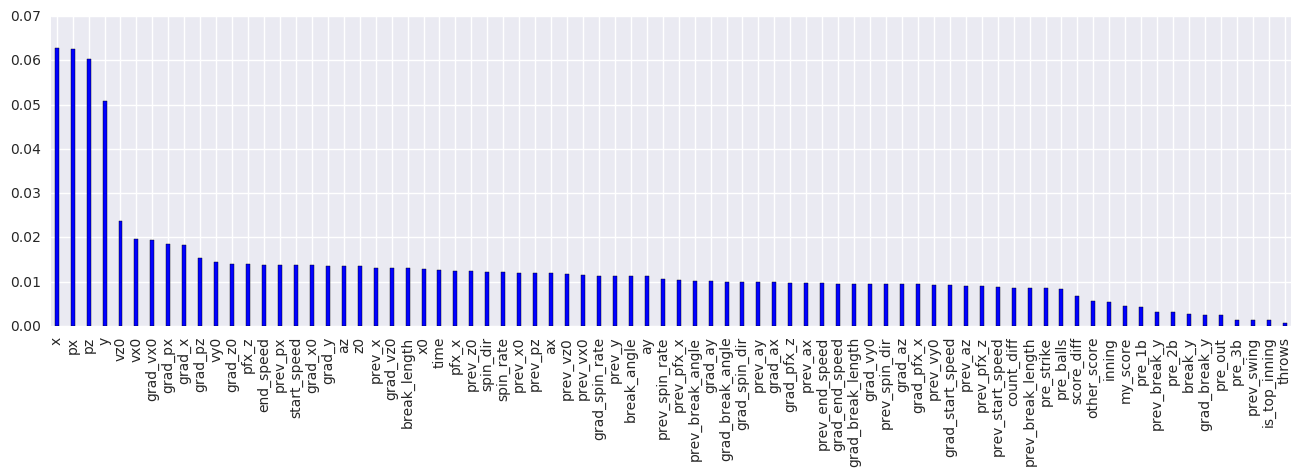

In [17]:
# feature importance plot
importance = pd.Series(rf_fit.feature_importances_,
                       index=X_train.columns)
indices = np.argsort(importance)[::-1]
importance[indices].plot.bar(color='blue', width=0.25, figsize=(16, 4))
plt.show()

As expected, the pitch location in the strike zone is relatively important (`px`, `pz`, `x`, `y`), as most batters are more likely to swing when the pitch is in the zone. The initial velocity and the difference in pitch location relative to the previous at-bat appear to be the next most important features.

Note that random forest feature importance is biased towards features with more values/levels. This is observed here, where many of the binary features appear to have the least importance.

Overall, many features appear to have similar importance (outside of the pitch location and the initial velocities out of the pitcher's hand). Therefore, I'll look to remove some features to reduce noise in the data set step by step, which in turn may improve the model.

### Features with engineered features removed

I'll begin by removing the raw previous pitch information (not the gradient from the previous pitches). The motivation for this is that it's not so much the actual pitch trajectory of the previous pitch that matters, but the relative difference in pitch trajectory between the previous pitch and the current pitch. Changing the hitter's eye could influence whether he swings the bat or not. Additionally, these were features that I engineered and could thus be noise in the model.

In [18]:
# remove highly-correlated features
prev_f = ['prev_px', 'prev_pz', 'prev_x0', 'prev_z0', 'prev_spin_rate', 'prev_spin_dir', 'prev_break_y',
          'prev_ax', 'prev_az', 'prev_vz0', 'prev_vx0', 'prev_ay', 'prev_break_angle', 'prev_start_speed',
          'prev_end_speed', 'prev_pfx_x', 'prev_pfx_z', 'prev_x', 'prev_y', 'prev_vy0', 'prev_break_length']
X1 = features.drop(prev_f, axis=1)

In [19]:
# train test split
X1_train, X1_test, y_train, y_test = split_data(X1, y, 0.7, 0)

In [20]:
# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf1_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X1_train, y_train)

In [21]:
# out-of-bag error
print("out-of-bag error: ", 1-rf1_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf1_fit.predict(X1_test)==y_test))

out-of-bag error:  0.219710144928
test error:  0.206718346253


Both the OOB and test errors have decreased compared to the models when using all features. Therefore, I will take the greedy approach and remove these features from the model without knowing whether they are actually important in later splits.

As a comparison, I will remove the gradient of pitch trajectory/location and calculate the training and test errors.

In [22]:
# remove highly-correlated features
grad_f = ['grad_px', 'grad_pz', 'grad_x0', 'grad_z0', 'grad_spin_rate', 'grad_spin_dir', 'grad_break_y',
          'grad_ax', 'grad_az', 'grad_vz0', 'grad_vx0', 'grad_ay', 'grad_break_angle', 'grad_start_speed',
          'grad_end_speed', 'grad_pfx_x', 'grad_pfx_z', 'grad_x', 'grad_y', 'grad_vy0', 'grad_break_length']
Xtemp = features.drop(grad_f, axis=1)

In [23]:
# train test split
Xtemp_train, Xtemp_test, y_train, y_test = split_data(Xtemp, y, 0.7, 0)

In [24]:
# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rftemp_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(Xtemp_train, y_train)

In [25]:
# out-of-bag error
print("out-of-bag error: ", 1-rftemp_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rftemp_fit.predict(Xtemp_test)==y_test))

out-of-bag error:  0.232463768116
test error:  0.22480620155


Both the OOB and test errors are higher when removing the pitch gradient features than when removing the raw previous pitch values. Thus, I will keep the gradient with respect the previous pitch in the model.

For completeness, I will remove all engineered features and examine the training and test errors.

In [26]:
# remove engineered features
X2 = features.drop(grad_f, axis=1)
X2 = Xtemp.drop(prev_f, axis=1)

In [27]:
# train test split
X2_train, X2_test, y_train, y_test = split_data(X2, y, 0.7, 0)

In [28]:
# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf2_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X2_train, y_train)

In [29]:
# out-of-bag error
print("out-of-bag error: ", 1-rf2_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf2_fit.predict(X2_test)==y_test))

out-of-bag error:  0.226666666667
test error:  0.227390180879


The OOB and test errors are both higher than those when just removing the previous pitch information. Therefore, I will proceed with just removing the previous pitch information. 

### Features with highly-correlated variables removed

From EDA, I found that many of the features where highly correlated. Therefore, I'll remove these highly-correlated features, which were identified primarily in the *eda* notebook.

In [30]:
# remove highly-correlated features
corr_f = ['x', 'grad_x', 'y', 'grad_y', 'end_speed', 'grad_end_speed',
          'vy0', 'grad_vy0', 'pfx_x', 'grad_pfx_x', 'pfx_z',
          'grad_pfx_z', 'break_length', 'grad_break_length']
X3 = X1.drop(corr_f, axis=1)

Now I'll split the test and training sets as before, being sure to use the same seed. Then I'll run the random forest classifier and estimate the errors.

In [31]:
# train test split
X3_train, X3_test, y_train, y_test = split_data(X3, y, 0.7, 0)

In [32]:
# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf3_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X3_train, y_train)

In [33]:
# out-of-bag error
print("out-of-bag error: ", 1-rf3_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf3_fit.predict(X3_test)==y_test))

out-of-bag error:  0.228405797101
test error:  0.220930232558


It appears that the OOB and test errors have both increased, though not by much. Therefore, I will not remove the highly-correlated features from the model at the moment.

### Features with least important features removed

Finally, I will remove the least important features from the list of features with previous pitch information already removed. Though feature importance estimates from random forest are known to be biased depending on the number of categories the feature has, I will still remove the binary features and observed the training and test errors.

In [34]:
# remove binary features
least_f = ['throws', 'pre_1b', 'pre_2b', 'pre_3b', 'prev_swing', 'is_top_inning', 'break_y', 'grad_break_y',
           'my_score', 'other_score', 'inning', 'pre_out', 'pre_strike', 'pre_balls']
X4 = X1.drop(least_f, axis=1)

In [35]:
# train test split
X4_train, X4_test, y_train, y_test = split_data(X4, y, 0.7, 0)

In [36]:
# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf4_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X4_train, y_train)

In [37]:
# out-of-bag error
print("out-of-bag error: ", 1-rf4_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf4_fit.predict(X4_test)==y_test))

out-of-bag error:  0.235942028986
test error:  0.21834625323


Both the OOB and test errors are higher than when just removing the previous pitch information. Therefore, there is evidence that suggests that these seemingly least important features should be left in the model.

### Just the two most important features

From the original feature importance estimates from random forest, it appeared that pitch location across the plate were by far the two most important features. I'll look into the predictive power of jus there two features.

In [38]:
# train test split
X5 = features[['px', 'pz']]
X5_train, X5_test, y_train, y_test = split_data(X5, y, 0.7, 0)

In [39]:
# initialize parameters
seed = 1000
nestimators = 1000

# initialize classifiers
rf5_fit = RandomForestClassifier(n_estimators=nestimators,
                                 criterion='gini',
                                 max_features='sqrt',
                                 random_state=seed,
                                 oob_score=True,).fit(X5_train, y_train)

In [40]:
# out-of-bag error
print("out-of-bag error: ", 1-rf5_fit.oob_score_)

# test error
print("test error: ", 1-np.mean(rf5_fit.predict(X5_test)==y_test))

out-of-bag error:  0.308405797101
test error:  0.280361757106


The OOB error and test errors as higher compared to the other feature subsets, suggesting that the other features are still important in this particular prediction problem. It still performs better than predicting no swing every pitch.

## Random forest model evaluation

To evaluate these random forest models on different subsets of features, I'll calculate their areas under the receiver operating characteristic (ROC) curves. These curves are plots of true positives vs false positives for different classification thresholds, and can be a good way to evaluate models when the distribution of binary outcomes is not highly skewed. Models with larger areas tend to have higher quality classification outputs. Note that these curves are calculated using the test data that were not used to build the models.

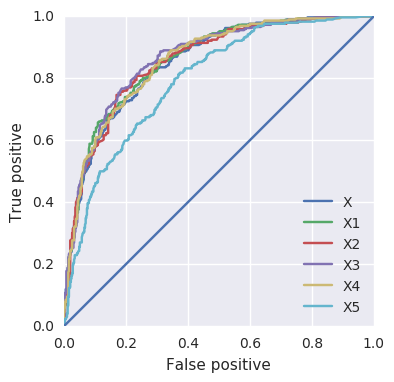

In [41]:
# import
from sklearn.metrics import roc_curve

# calculate false positive and true negative rates
preds = [rf_fit.predict_proba(X_test)[:, 1],
         rf1_fit.predict_proba(X1_test)[:, 1],
         rf2_fit.predict_proba(X2_test)[:, 1],
         rf3_fit.predict_proba(X3_test)[:, 1],
         rf4_fit.predict_proba(X4_test)[:, 1],
         rf5_fit.predict_proba(X5_test)[:, 1],]
dats = ['X', 'X1', 'X2', 'X3', 'X4', 'X5']

# plot curves
fig, ax = plt.subplots()
for pred in preds:
    false_pos, true_pos, _ = roc_curve(y_test, pred)
    ax.plot(false_pos, true_pos)
ax.plot([0, 1], [0, 1])
ax.legend(dats, loc=4)
ax.set_aspect('equal', 'box')
ax.set_xlabel('False positive')
ax.set_ylabel('True positive')
plt.show()

In [42]:
# import
from sklearn.metrics import roc_auc_score

# calculate area under roc curve
print("Area under ROC curve:")
for ii in range(len(preds)):
    print(dats[ii], ":", roc_auc_score(y_test, preds[ii]))

Area under ROC curve:
X : 0.85221039618
X1 : 0.858690246121
X2 : 0.855077303473
X3 : 0.863930256352
X4 : 0.856441482408
X5 : 0.792751378389


All models appear to have similar areas under the curve, aside from the model built from just the two plate-location parameters (*X5*; it actually still has pretty good performance). However, the random forest model using data subset *X3* (removed previous pitch values and highly correlated variables) appears to perform the best. Therefore, I will use this subset of features when evaluating other classification models.

Finally, I'll look at the feature importance estimates from random forest on data subset *X3*.

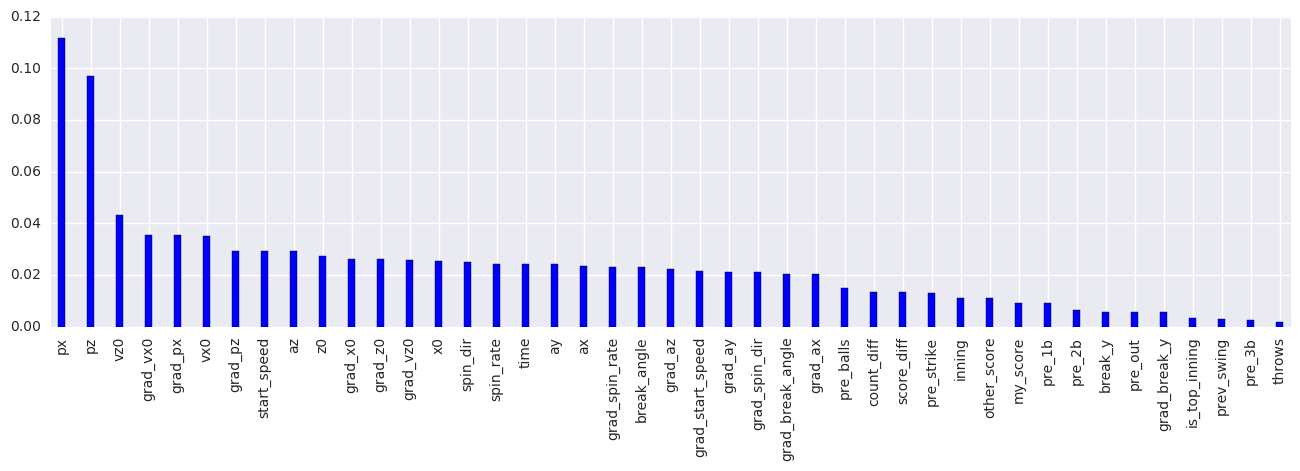

In [43]:
# feature importance plot
importance = pd.Series(rf3_fit.feature_importances_,
                       index=X3_train.columns)
indices = np.argsort(importance)[::-1]
importance[indices].plot.bar(color='blue', width=0.25, figsize=(16, 4))
plt.show()

It appears that the two most important features to determining whether Cust will swing his bat are horizontal and vertical pitch location (`px`, `pz`). This is expected, as batters usually try to swing at pitches in the strike zone and not outside of it. Then, it appears that the vertical velocity of the ball out of the pitcher's hand (`vz0`) is the next most important feature, suggesting that vertical movement of a pitch could be a useful feature for swing prediction.

## Model evaluation

Next I'll evaluate the predictions from the random forest model. First, I'll create a confusion matrix.

Normalized confusion matrix
[[ 0.90248963  0.09751037]
 [ 0.42465753  0.57534247]]


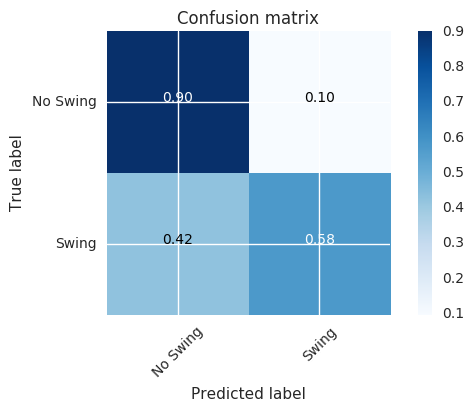

In [44]:
# import
import itertools
from sklearn.metrics import confusion_matrix

# calculate confusion matrix
cm = confusion_matrix(y_test, rf3_fit.predict(X3_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # clean up
    return plt

# plot confusion matrix
plot_confusion_matrix(cm,
                      classes=['No Swing', 'Swing'],
                      normalize=True,)
plt.show()

Now I'll create histograms of the scores from both groups of outcomes. Ideally, the probabilities for all actual non-swings (negatives) will be close to zero, while the probabilities for all actual swings (positives) will be close to one. Observing these histograms can provide insight into model performance issues.

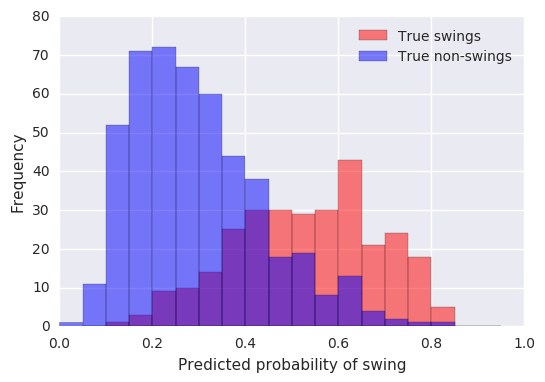

In [45]:
# grab all actual swings
swing1 = np.array(y_test==1)
swing1_pred = rf3_fit.predict_proba(X3_test)[swing1, 1]

# grab all actual non-swings
swing0 = np.array(y_test==0)
swing0_pred = rf3_fit.predict_proba(X3_test)[swing0, 1]

# plot histograms
bins = np.arange(0, 1, 0.05)
fig, ax = plt.subplots()
ax.hist(swing1_pred, bins=bins, alpha=0.5, color='r')
ax.hist(swing0_pred, bins=bins, alpha=0.5, color='b')
ax.legend(['True swings', 'True non-swings'])
ax.set_xlabel('Predicted probability of swing')
ax.set_ylabel('Frequency')
plt.show()

Overall, it is clear that the model is biased toward non-swings, as most of the prediction probabilities are skewed toward lower probabilities (toward non-swing predictions). This is likely because the data used for training the model is also skewed toward non-swings (62% of pitches were not swung at), so the model has not seen enough swings (relative to non-swings) to improve their prediction.

In the future, model performance could be potentially improved by balancing the classes in the training data. Possible approaches to adjusting for the initial class imbalance is to remove non-swing data points or resample (with replacement) swing data points such that the number of swings and non-swings in the training data are the same. The resulting model can be tested on the unbalanced test data, hopefully producing better performance.

In [46]:
# clean up
hdb.close()

## Final thoughts

Random forest appears to perform much better than random guessing at predicting whether this particular batter will swing at a pitch or not. While feature selection here was based on a greedy approach evaluated on the OOB and test errors, the area under the ROC curves suggested that the subset of features where previous pitch information and highly correlated variables are removed produced the best model.

However, the exact errors are subject to the exact split of the data into training and test sets, suggesting that the selected features should be taken with caution. Additionally, interpretability of the most important features should be taken with caution, given the bias from the random forest output toward features with more possible values. Note that it does make sense that pitch location is apparently the most important feature, though.

Because the area under the ROC curves area are all similar, I will proceed with using the suggested subset of features here when fitting other models to the data.